# Imports


In [1]:
import pandas as pd 
import numpy as np

import random

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns


from scipy.stats import ttest_ind


In [2]:
import warnings
warnings.filterwarnings( 'ignore' )

# Helper Functions

In [3]:
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe.converted == True].groupby(column_names)['user_id'].nunique()

    # Total number users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate


def retention_rate(dataframe, column_names):
    
    # Group by column_names and calculate retention
    retained = dataframe[dataframe['is_retained'] == True].groupby(column_names)['user_id'].nunique()

    # Group by column_names and calculate conversion

    converted = dataframe[dataframe['converted'] == True]\
    .groupby(column_names)['user_id'].nunique()

    retention_rate = retained/converted
    return retention_rate

def plotting_conv(dataframe, name='conversion', rotation= None):
    for column in dataframe:
        # Plot column by dataframe's index
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + str(column) + ' ' + name+ ' rate\n', 
                  size = 16)
        plt.ylabel(name +' rate', size = 14)
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation = rotation)
        # Show plot
        plt.show()  ;
        plt.clf();

In [4]:
def country_name(x):
    if x['Country_Number'] == 1:
        return 'United States'
    elif x['Country_Number'] == 2:
        return 'Canada'
    elif x['Country_Number'] == 3:
        return 'Brazil'
    elif x['Country_Number'] == 4:
        return 'France'
    elif x['Country_Number'] == 5:
        return 'Mexico'
    else:
        pass

# Dataframes

## Create dataframes

In [5]:
# Create a dictionary with sample sales data

start_date = '2022-01-01'
end_date = '2022-12-31'

# Generate 400 random dates in the range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

sales_data = {
    'Date': np.random.choice(date_range, size=400),
    'Number of Website Visitors': [random.randint(100, 1000) for _ in range(400)],
    'Number of Orders': [random.randint(10, 100) for _ in range(400)],
    'Revenue': [random.randint(1000, 10000) for _ in range(400)],
    'Marketing Spend': [random.randint(100, 1000) for _ in range(400)],
    'Number of Customers': [random.randint(5, 20) for _ in range(400)],
    'user_id': [random.randint(580, 2000) for _ in range(400)],
    'converted': np.random.choice([True, False], size=400)
    
}

# Create a pandas dataframe from the dictionary
sales_data_df = pd.DataFrame(sales_data)

# Save the dataframe to a CSV file
#sales_data_df.to_csv('./data/sales_data.csv', index=False)

In [6]:
sales_data = pd.read_csv('./data/sales_data.csv', parse_dates=['Date'])

sales_data = sales_data.sort_values(by='Date')
sales_data.head(3)


,Date,Number of Website Visitors,Number of Orders,Revenue,Marketing Spend,Number of Customers,user_id,converted
53,2022-01-03,692,87,6677,574,9,789,False
131,2022-01-07,530,68,8017,435,9,1644,True
43,2022-01-08,331,34,4265,959,14,644,False


In [7]:


df1 = pd.DataFrame(np.random.randint(9,11,size=(1100, 1)), columns=['How likely would you reccomend the product?']) #promoters
df2 = pd.DataFrame(np.random.randint(7,9,size=(300, 1)), columns=['How likely would you reccomend the product?']) #passives
df3 = pd.DataFrame(np.random.randint(1,7,size=(100, 1)), columns=['How likely would you reccomend the product?']) #detractors

df = pd.concat([df1,df2,df3], ignore_index=True)

df['Country_Number'] = np.random.randint(1, 6, df.shape[0]) 
df['user_id'] = np.random.randint(1, 410, df.shape[0]) 
df['Traveler_Type'] = np.random.choice(['Business', 'Leisure'], size=df.shape[0]) 
df['Country'] = df.apply(country_name, axis=1)


df['Traveler_type_Number']= df['Traveler_Type'].apply(lambda x: 0 if x == 'Business' else  1  if x == 'Leisure' else None )

In [8]:
np.random.seed(42)

rand_nums = []
user= []
for user_id in df.user_id.unique():
    rand_num = np.round(np.random.uniform(0.9,1), 2)
    user.append(user_id)
    # Append the random number to the list
    rand_nums.append(rand_num)
    df_influence = pd.DataFrame({'user_id': user, 'influence': rand_nums})




In [9]:
df_all = pd.merge(df, df_influence, on= 'user_id')
#df_all.to_csv('data/df_all.csv')

In [10]:
survey_data = df_all[['user_id','Country','Traveler_Type','influence', 'How likely would you reccomend the product?']].rename(columns={'How likely would you reccomend the product?':'Score'})


survey_data['score_weighted'] =round(( survey_data['Score'] * survey_data.influence),1 )

survey_data['nps_bucket'] = survey_data['score_weighted'].apply(lambda x: 'promoters' if x >= 8.5 else 
                                                      'detractors' if x <= 6.0 else
                                                      'passives' if (x > 6.0 and x < 8.5) else 'no score')
#survey_data.to_csv('./data/survey_data.csv', index=False)



## Import data

In [11]:
marketing = pd.read_csv('./data/marketing_new.csv', parse_dates=['date_served', 'date_subscribed', 'date_canceled'])

In [12]:
# Change the data type of a column
marketing['is_correct_lang'] = marketing['is_correct_lang'].astype('bool')


In [13]:
survey_data = pd.read_csv('./data/survey_data.csv')

In [14]:
survey_data.head()

,user_id,Country,Traveler_Type,influence,Score,score_weighted,nps_bucket
0,304,Mexico,Business,0.94,9,8.5,promoters
1,304,United States,Leisure,0.94,9,8.5,promoters
2,304,France,Business,0.94,9,8.5,promoters
3,304,Mexico,Business,0.94,9,8.5,promoters
4,304,Mexico,Leisure,0.94,10,9.4,promoters


# KPI´s 

## Conversion rate

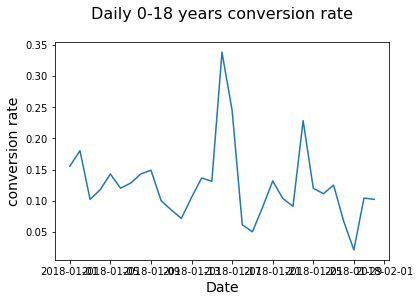

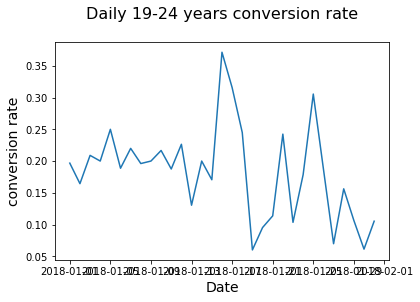

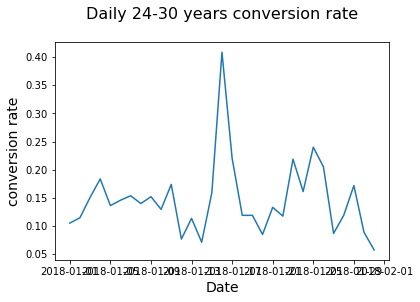

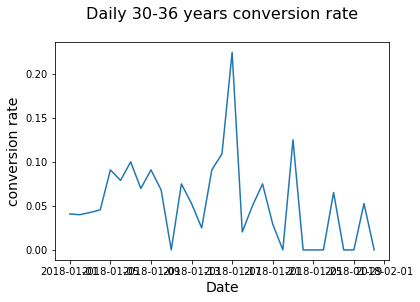

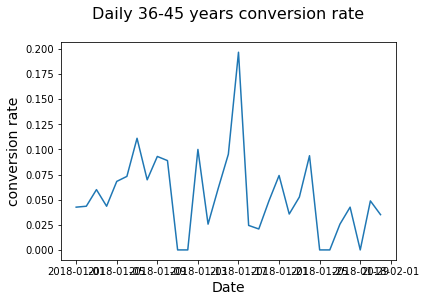

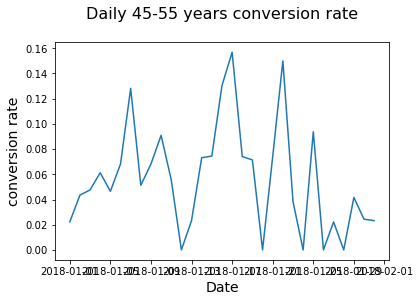

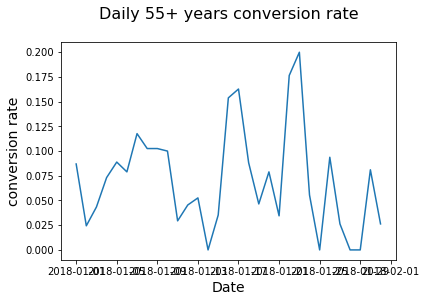

<Figure size 432x288 with 0 Axes>

In [15]:
# Calculate conversion rate by date served and age group
age_group_conv = conversion_rate(marketing, ['date_served','age_group' ])

# Unstack age_group_conv and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Plot the results
plotting_conv(age_group_df)

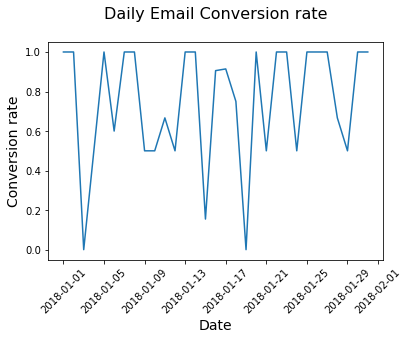

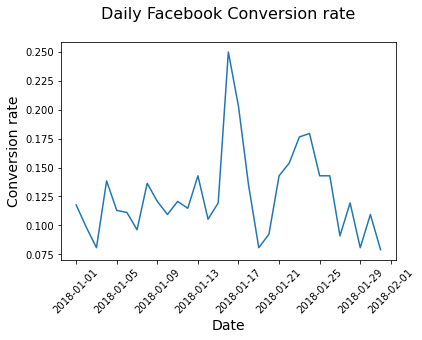

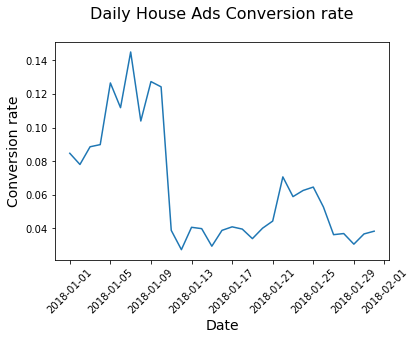

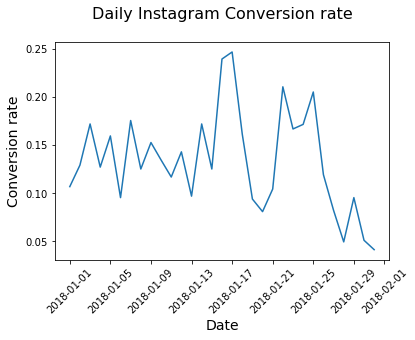

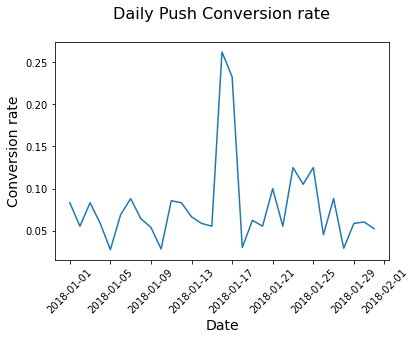

<Figure size 432x288 with 0 Axes>

In [16]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plotting_conv(daily_conv_channel,'Conversion' , 45)

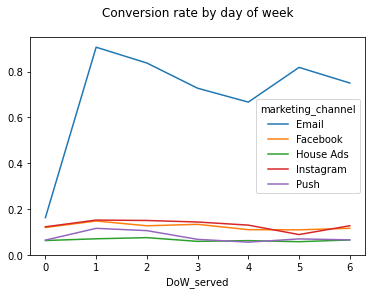

In [17]:
#identifyng potential causes for the decrease.
# Add day of week column to marketing
marketing['DoW_served'] = marketing.date_served.dt.dayofweek


# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(marketing, ['DoW_served', 'marketing_channel'])


# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot()
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

## Retention rate

In [18]:
daily_retention = retention_rate(marketing,['date_subscribed','subscribing_channel'])

daily_retention = pd.DataFrame(daily_retention.unstack(level=1))




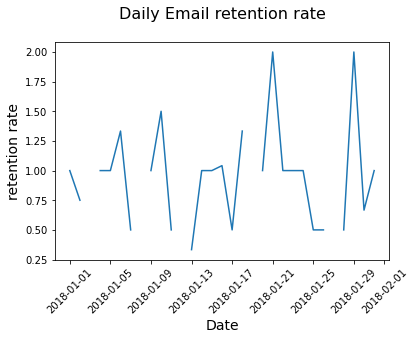

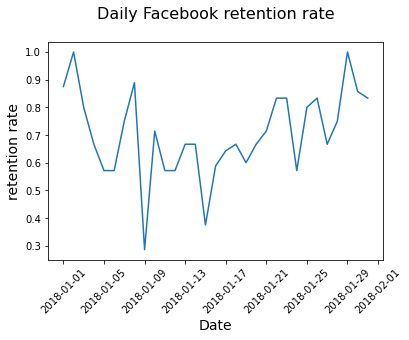

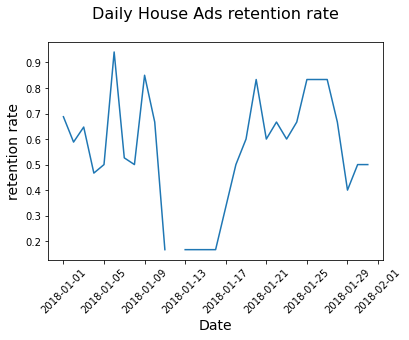

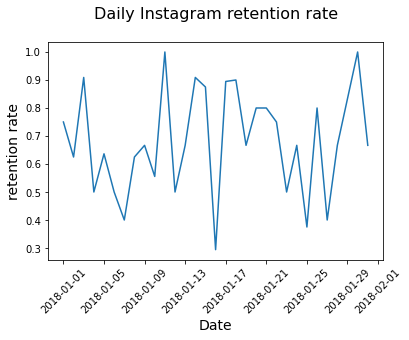

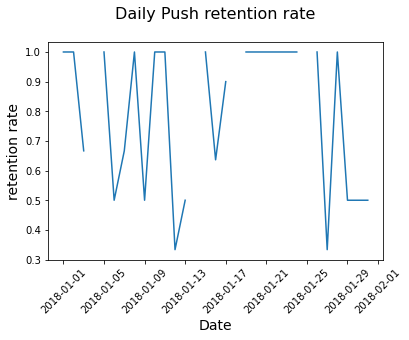

<Figure size 432x288 with 0 Axes>

In [19]:
plotting_conv(daily_retention, 'retention', 45)

## Total Revenue


In [20]:
# Calculate total sales revenue
total_revenue = sales_data['Revenue'].sum()

print('Total sales revenue: $', total_revenue)

Total sales revenue: $ 2292398


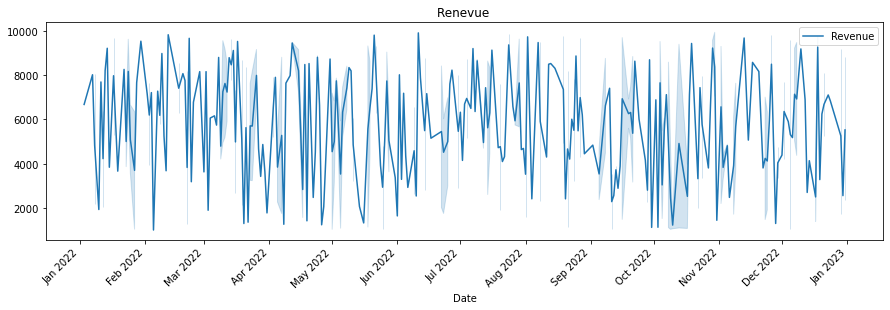

In [21]:
lineplot = sales_data.set_index('Date')

fig = plt.subplots(figsize = (15,4))

sns.lineplot( data=lineplot[['Revenue']])
plt.xticks(rotation=45, ha='right')
plt.title('Renevue ')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show();

In [22]:
split_date = sales_data['Date'].iloc[len(sales_data) // 2]


In [23]:
# Load sales data for two periods
sales_data_period_1 = sales_data[sales_data['Date'] < split_date]
sales_data_period_2 = sales_data[sales_data['Date'] >= split_date]

# Calculate sales revenue for each period
revenue_period_1 = sales_data_period_1['Revenue'].sum()
revenue_period_2 = sales_data_period_2['Revenue'].sum()

# Calculate sales growth rate
sales_growth_rate = (revenue_period_2 - revenue_period_1) / revenue_period_1 * 100

print('Sales growth rate: ', round(sales_growth_rate, 2), '%')


Sales growth rate:  -3.24 %


## CAC , AVERAGE ORDER VALUE

In [24]:

# Calculate the conversion rate
conversion_rate = (sales_data['Number of Orders'] / sales_data['Number of Website Visitors']) * 100

# Calculate the average order value
average_order_value = sales_data['Revenue'] / sales_data['Number of Orders']

# Calculate the customer acquisition cost - Hypothetically if all the costs (mkt, sales, etc) was in mkt spend
cac = (sales_data['Marketing Spend'].sum() / sales_data['Number of Customers'].sum() )
print("The CAC is:", round(cac, 2))


The CAC is: 45.81


## **The Net Promoter Score (NPS)**

is loyalty metric used in marketing to measure the number of satisfied customers and the average degree of satisfaction.

In [25]:
survey_data.nps_bucket.value_counts(normalize=True)*100

promoters     59.600000
passives      33.733333
detractors     6.666667
Name: nps_bucket, dtype: float64

In [26]:
# Calculate percentage of promoters, detractors, and passives
promoters = round(survey_data[survey_data.nps_bucket == 'promoters']['user_id'].count() / len(survey_data) * 100, 2 )
detractors = round(survey_data[survey_data.nps_bucket == 'detractors']['user_id'].count() / len(survey_data) * 100, 2 )
passives = round(survey_data[survey_data.nps_bucket == 'passives']['user_id'].count() / len(survey_data) * 100, 2 )

# Calculate NPS
nps = promoters - detractors 


print(f"Promoters: {promoters:.2f}%")
print(f"Detractors: {detractors:.2f}%")
print(f"Passives: {passives:.2f}%")
print(f"NPS: {nps:.2f}")



Promoters: 59.60%
Detractors: 6.67%
Passives: 33.73%
NPS: 52.93


In [27]:
# NPS score for each segment (country and traveler´s type) 

grouped_df = survey_data.groupby(['Country','Traveler_Type'])['nps_bucket'].apply(
    lambda x: (x.str.contains('promoters').sum() - x.str.contains('detractors').sum()) / 
    (x.str.contains('promoters').sum() + x.str.contains('passives').sum() 
     + x.str.contains('detractors').sum())).reset_index()
grouped_df


,Country,Traveler_Type,nps_bucket
0,Brazil,Business,0.496350
1,Brazil,Leisure,0.558621
2,Canada,Business,0.496599
3,Canada,Leisure,0.591837
4,France,Business,0.511111
5,France,Leisure,0.515528
6,Mexico,Business,0.542857
7,Mexico,Leisure,0.617834
8,United States,Business,0.476190
9,United States,Leisure,0.490798


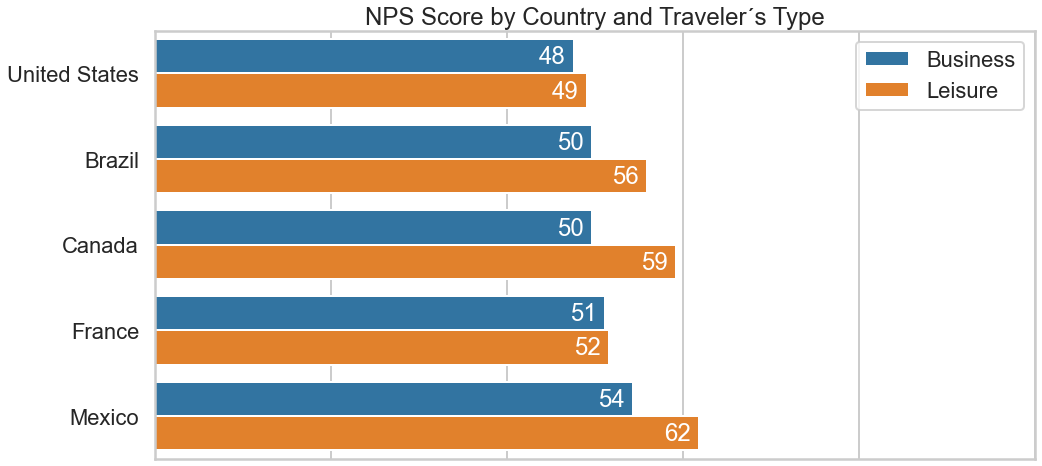

In [28]:
sns.set_style("whitegrid")
sns.set_context("poster", font_scale = 1)
f, ax = plt.subplots(figsize=(15,7))

sns.barplot(data = grouped_df.sort_values(by='nps_bucket', ascending=True), 
            x = 'nps_bucket', 
            y='Country', 
            hue='Traveler_Type',
               ax=ax)
ax.set(ylabel='',xlabel='', title = 'NPS Score by Country and Traveler´s Type')
ax.set_xlim(0,1)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.legend()

#data labels
for p in ax.patches:
    ax.annotate("{:.0f}".format(p.get_width()*100),
                (p.get_width(), p.get_y()),
                va='center', 
                xytext=(-35, -18), #offset points so that the are inside the chart
                textcoords='offset points', 
                color = 'white')
    
plt.tight_layout()
plt.show()

Evaluating statistical significance

In [ ]:


t = ttest_ind(control, personalized)
print(t)

Building an A/B test segmenting function

In [ ]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

# Use ab_segmentation on language displayed
ab_segmentation('language_displayed')

You found that personalization was extremely effective for younger groups but less effective than the control for older groups. One explanation might be that younger users understand how their data might be used online and think personalization is cool because it gives them more insight into themselves while older people might feel that this is a violation of their privacy.